## 저장된 모델 불러오기

In [1]:
import torch
import os

sample = torch.load(os.path.join(os.getcwd(), '2021-05-04-13:55/checkpoint/ckpt.pth'))

In [2]:
import torchvision.models as models
import torch.nn as nn

resnet18 = models.resnet18(pretrained = False)

resnet18.fc = nn.Linear(512, 2)
print(resnet18.fc)

Linear(in_features=512, out_features=2, bias=True)


In [3]:
resnet18.load_state_dict(sample['net'])

<All keys matched successfully>

## CAM 만들기

In [4]:
import cv2
import torchvision
import torchvision.transforms as transforms
import datetime
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4876, 0.4544, 0.4165), (0.2257, 0.2209, 0.2212)),
])

test_dataset = torchvision.datasets.ImageFolder(root = os.path.join(os.getcwd(), 'CatvsDog_test'), transform = transform_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 1, shuffle = True, num_workers = 0)


current_time = datetime.datetime.now() + datetime.timedelta(hours= 9)
current_time = current_time.strftime('%Y-%m-%d-%H:%M')


saved_loc = os.path.join('./', current_time)
if os.path.exists(saved_loc):
    shutil.rmtree(saved_loc)
os.mkdir(saved_loc)

print("결과 저장 위치: ", saved_loc)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

결과 저장 위치:  ./2021-05-07-12:49


In [5]:
resnet18.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True label : 1, Predicted label : 1, Probability : 1.00


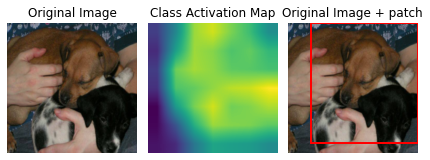

True label : 0, Predicted label : 0, Probability : 1.00


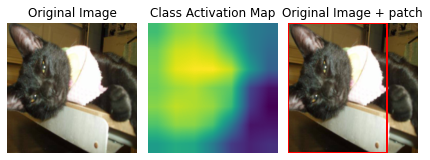

True label : 0, Predicted label : 0, Probability : 1.00


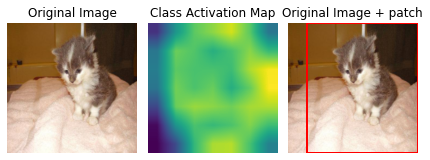

In [17]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy.ndimage import label
from skimage.measure import regionprops
import matplotlib

# final conv layer name 
finalconv_name = 'layer4'

# inference mode
resnet18.eval()

# number of result
num_result = 3


feature_blobs = []

# output으로 나오는 feature를 feature_blobs에 append하도록
def hook_feature(module, input, output):
    feature_blobs.append(output.cpu().data.numpy())
    
resnet18._modules.get(finalconv_name).register_forward_hook(hook_feature)

# get the softmax weight
params = list(resnet18.parameters())
weight_softmax = np.squeeze(params[-2].cpu().detach().numpy()) # [2, 512]


# generate the class activation maps
def returnCAM(feature_conv, weight_softmax, class_idx):
    size_upsample = (224, 224)
    _, nc, h, w = feature_conv.shape # nc : number of channel, h: height, w: width
    output_cam = []
    # weight 중에서 class index에 해당하는 것만 뽑은 다음, 이를 conv feature와 곱연산
    cam = weight_softmax[class_idx].dot(feature_conv.reshape((nc, h*w))) 
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    cam_img = np.uint8(255 * cam_img)
    output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

def generate_bbox(img, cam, threshold):
    labeled, nr_objects = label(cam > threshold)
    props = regionprops(labeled)
    return props

for i, (image, target) in enumerate(test_loader):
    
    # 모델의 input으로 주기 위한 image는 따로 설정
    image_for_model = image.clone().detach()

    # Image denormalization, using mean and std that i was used.
    image[0][0] *= 0.2257
    image[0][1] *= 0.2209
    image[0][2] *= 0.2212
    
    image[0][0] += 0.4876
    image[0][1] += 0.4544
    image[0][2] += 0.4165
    
    fig = plt.figure(tight_layout = True)
    rows = 1
    cols = 3
    
    ax1 = fig.add_subplot(rows, cols, 1)
    ax1.imshow(np.transpose(image[0].numpy(), (1, 2, 0)))
    ax1.set_title("Original Image")
    ax1.axis("off")
    
    image_PIL = transforms.ToPILImage()(image[0])
    image_PIL.save(os.path.join(saved_loc, 'img%d.png' % (i + 1)))
    
    # 모델의 input으로 사용하도록.
    image_tensor = image_for_model.to(device)
    logit = resnet18(image_tensor)
    h_x = F.softmax(logit, dim=1).data.squeeze()
    
    probs, idx = h_x.sort(0, True)
    print("True label : %d, Predicted label : %d, Probability : %.2f" % (target.item(), idx[0].item(), probs[0].item()))
    
    CAMs = returnCAM(feature_blobs[0], weight_softmax, [idx[0].item()])
    img = cv2.imread(os.path.join(saved_loc, 'img%d.png' % (i + 1)))
    height, width, _ = img.shape
    heatmap = cv2.applyColorMap(cv2.resize(CAMs[0], (width, height)), cv2.COLORMAP_JET)
    result = heatmap * 0.7 + img * 0.5
    cv2.imwrite(os.path.join(saved_loc, 'cam%d.png' % (i + 1)), result)
    
    props = generate_bbox(img, CAMs[0], CAMs[0].max()*0.6)
    
    ax2 = fig.add_subplot(rows, cols, 2)
    im2 = ax2.imshow(CAMs[0])
    ax2.set_title("Class Activation Map")
    ax2.axis("off")
    
    ax3 = fig.add_subplot(rows, cols, 3)
    ax3.imshow(np.transpose(image[0].numpy(), (1, 2, 0)))
    ax3.set_title("Original Image + patch")
    ax3.axis("off")
    
    for b in props:
        bbox = b.bbox
        xs = bbox[1]
        ys = bbox[0]
        w = bbox[3] - bbox[1]
        h = bbox[2] - bbox[0]
        
        rect = matplotlib.patches.Rectangle((xs, ys), w, h, linewidth = 2, edgecolor = 'r', facecolor = 'none')
        ax3.add_patch(rect)
    
    
    plt.savefig(os.path.join(saved_loc, 'Result%d.png' % (i+1)))
    
    plt.show()
    
    if i + 1 == num_result:
        break
        
    feature_blobs.clear()
